#Large Cap US Stock Analysis
NVDA- NVIDIA
MS- Morgan Stanley
BX-  Blackstone
JPM- JP Morgan
GE- General Electric Aerospace

#Importing 
Note:define tickers here and store their csv file in data folder in the same directory as this notebook

In [1]:
tickers = ["NVDA", "MS", "BX", "JPM", "GE"]
# tickers = ["AAPL", "MSFT", "TSLA", "AMZN", "GOOGL"]


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Function to clear up and missing info - use interpolation to fill most data, then forward fill and backward fill for edge cases at top edge and bottom edge, if data is reliable, we can add argument (limit=1) for ffill and bfill, but if not, then then omitting it helps take care of block of missing value at top and bottom edge.

In [2]:
def cleanDF(df):
    df.interpolate(method="linear", inplace=True, limit_direction="both")

    #for edge cases
    df.ffill(inplace=True)
    df.bfill(inplace=True)
    return df

#Function to filter the dataframe to a certain set of period of years from the last available data's date

In [3]:
def filterYearPeriod(df, years):
    #since the data is only recorded to around 2017, taking last data's date as the end of of our period
    #Note: the date needs to be in datetime format
    lastDate = df['Date'].max()

    #defining a cutoff date for time, years can be changed according to will
    noOfYears=years
    cutoffDate = lastDate -  pd.DateOffset(years = noOfYears)

    df = df[df['Date'] >= cutoffDate]
    return df
    

#Function to find the technical indicators for df and add them as columns:
Daily Return: % change in closing price
7-day Moving Average of closing price
30-day Moving Average of closing price
Rolling Volatility (30d): Standard deviation of returns over the last 30 days

In [4]:
def addTechnicalIndicators(df):
    #daily return (%)
    df['Daily Return (%)'] = df['Close'].pct_change()*100
    #using min_periods=1 to allow row 2 and onwards to have data. row 1 for daily return and std deviation cannot have data as no preceding data to work on for ma it can still just use current closing value
    #7 day moving average
    df['7-Day Moving Average'] = df['Close'].rolling(window=7, min_periods=1).mean()
    #30 day moving average
    df['30-Day Moving Average'] = df['Close'].rolling(window=30, min_periods=1).mean()
    #rolling volatility over 30 days
    df['Rolling Volatility (30d)'] =  df['Close'].rolling(window=30, min_periods=1).std()
    return df
    

#Importing Data and Loading to MultiIndexed DataFrames with Ticker and Date as Indices
Converting Date to datetime format
Then cleaning up to fill missed values using interpolation or forward fill 

In [5]:
dataFrames = {}
period=10

for ticker in tickers:
    dataFrame = pd.read_csv(f'data/{ticker.lower()}.us.txt')
    #converting date to datetime format
    dataFrame['Date'] = pd.to_datetime(dataFrame['Date'])
    #sorting on basis of date
    dataFrame.sort_values('Date', inplace=True)
    #filtering last 10 years data
    dataFrame = filterYearPeriod(dataFrame, period)

    #filling missing values
    dataFrame = cleanDF(dataFrame)
    #adding ticker column
    dataFrame['Ticker'] = ticker
    dataFrame.set_index(['Ticker', 'Date'], inplace=True)
    dataFrame = addTechnicalIndicators(dataFrame)
    
    dataFrames[ticker]= dataFrame
    



#Now we compute the stock with greatest average daily return and the one with highest mean rolling volatility

In [6]:
def avgReturn(df):
    return df['Daily Return (%)'].mean()
def meanMonthlyRollingVolatility(df):
    #creating a deep copy to not change original file
    sudodf = df.copy(deep=True)
    #adds another column with datetime only accurate to the month to help get monthly rolling volatility
    sudodf['Year-Month'] =  sudodf.index.get_level_values('Date').to_period('M')
    #df of monthtly volatility
    monthlyVolatility = sudodf.groupby(['Year-Month'])['Rolling Volatility (30d)'].mean()

    #now finding most volatile month and volatility in that month
    month = monthlyVolatility.idxmax()
    volatility = monthlyVolatility.max()

    return [monthlyVolatility, month, volatility]
    
    
    

#Now we use these functions to get average daily return and volatility and format and print the information for each of them

In [7]:
avgReturns=[]
greatestMonthlyAvgVolatility=[]
correspondingMonths=[]
for i,dataFrame in enumerate(dataFrames.values()):
    avgRet=avgReturn(dataFrame)
    print(f"{tickers[i]} had a average daily return of {avgRet}% over the last 10 years of data.")
    avgReturns.append(avgRet)
    
    vol = meanMonthlyRollingVolatility(dataFrame)
    print(f"{tickers[i]} had the most volatile month - {vol[1]} with a average volatility of {vol[2]}")
    greatestMonthlyAvgVolatility.append(vol[2])
    correspondingMonths.append(vol[1])
    print("\n")
print("\n")
greatestAvgReturn=max(avgReturns)
for i,ele in enumerate(avgReturns):
    if avgReturns[i]==greatestAvgReturn:
        print(f"The stock {tickers[i]} had the greatest average daily return of {greatestAvgReturn}")
        print("\n")
print("\n")
maximumVolatility = max(greatestMonthlyAvgVolatility)
maximumVolatilityStock = []
for i,ele in enumerate(greatestMonthlyAvgVolatility):
    if ele == maximumVolatility:
        maximumVolatilityStock.append([tickers[i], correspondingMonths[i]])
for stock in maximumVolatilityStock:
    print(f"The stock {stock[0]} had the most volatile month - {stock[1]} with a volatility of {maximumVolatility}.")
    print("\n")
    

NVDA had a average daily return of 0.12730351226431078% over the last 10 years of data.
NVDA had the most volatile month - 2017-06 with a average volatility of 13.53175146223827


MS had a average daily return of 0.06601437652132638% over the last 10 years of data.
MS had the most volatile month - 2008-10 with a average volatility of 6.490579369818003


BX had a average daily return of 0.07887596264205966% over the last 10 years of data.
BX had the most volatile month - 2015-09 with a average volatility of 1.8072392716917705


JPM had a average daily return of 0.07818065788101278% over the last 10 years of data.
JPM had the most volatile month - 2016-12 with a average volatility of 4.456886146206948


GE had a average daily return of 0.0036271234087836687% over the last 10 years of data.
GE had the most volatile month - 2008-10 with a average volatility of 2.1187446523564666




The stock NVDA had the greatest average daily return of 0.12730351226431078




The stock NVDA had the most 

#To visualize the data we use matplotlib
Creating function to specify parameter and tickers to plot

In [8]:
def createPlot(tickers, parameter):
    plt.figure(figsize=(16, 8))
    for ticker in tickers:
        try:
            df = dataFrames[ticker]
            dates = df.index.get_level_values('Date')
            try:
                parameterValues = df[parameter]
                plt.plot(dates, parameterValues, label=ticker)
            except:
                print(f"Invalid parameter- {parameter}")

        except KeyError:
            print(f"Ticker- {ticker} does not exist")
    #to check if atleast one valid plot has been added
    if plt.gca().lines !=0:
        plt.title(f'{parameter} of Selected Stocks Over Last {period} Years of Available Data')
        plt.xlabel('Date')
        plt.ylabel(parameter)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        

#Using above function to make plots for closing price, daily return and other techincal indicators

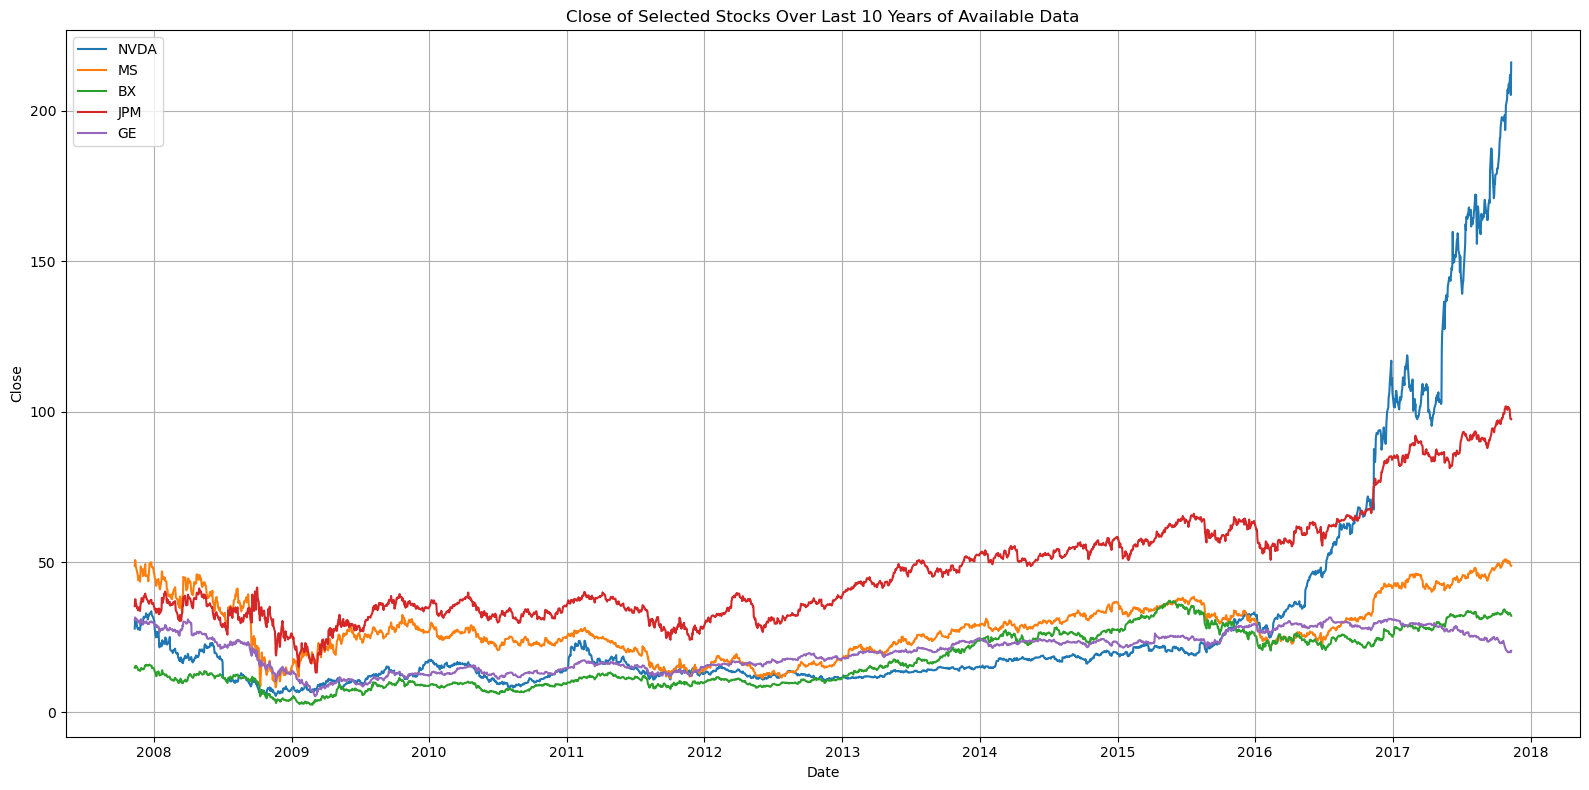

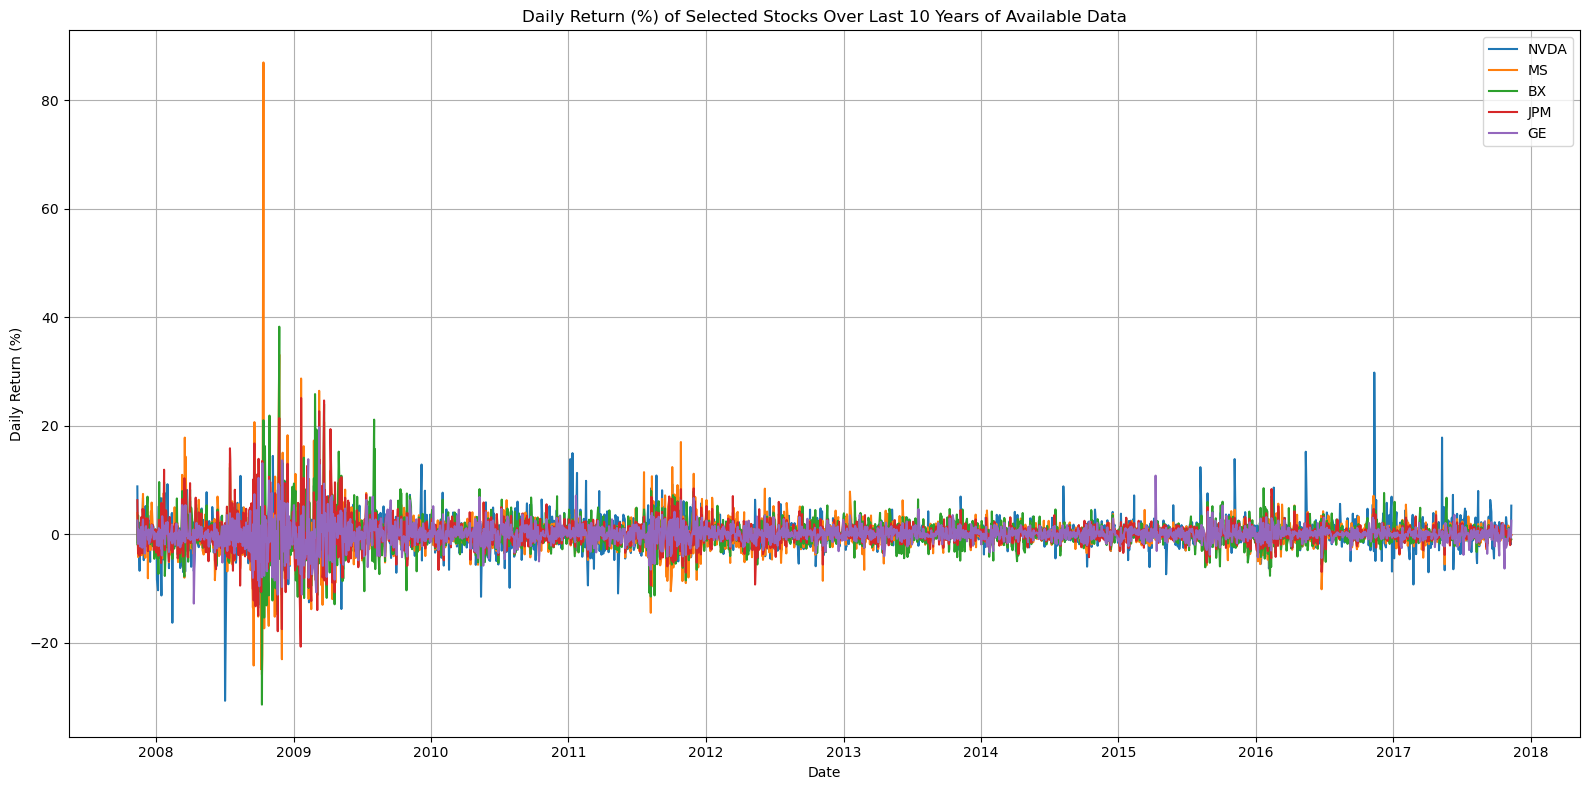

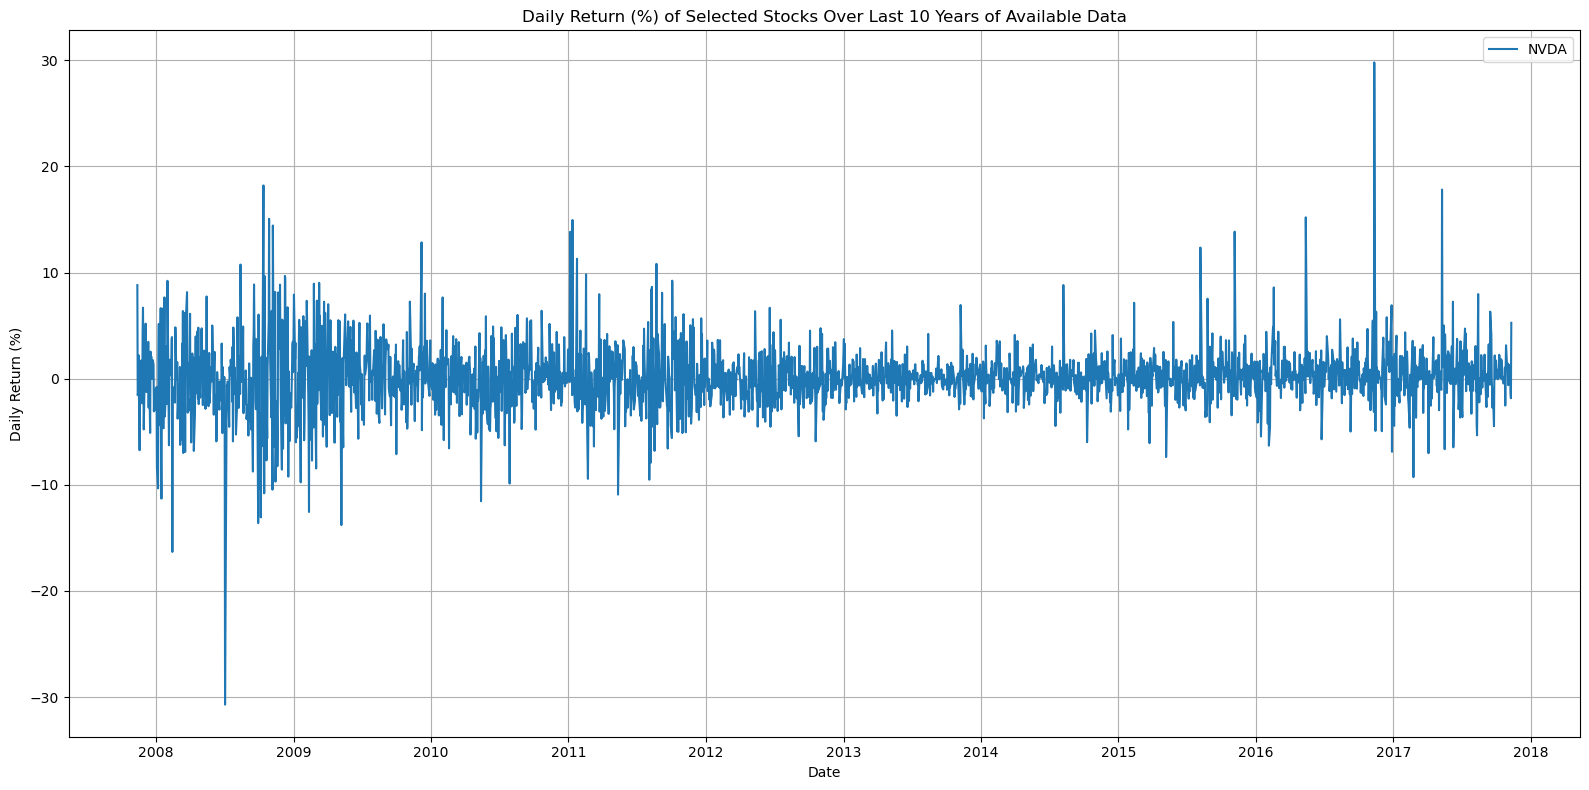

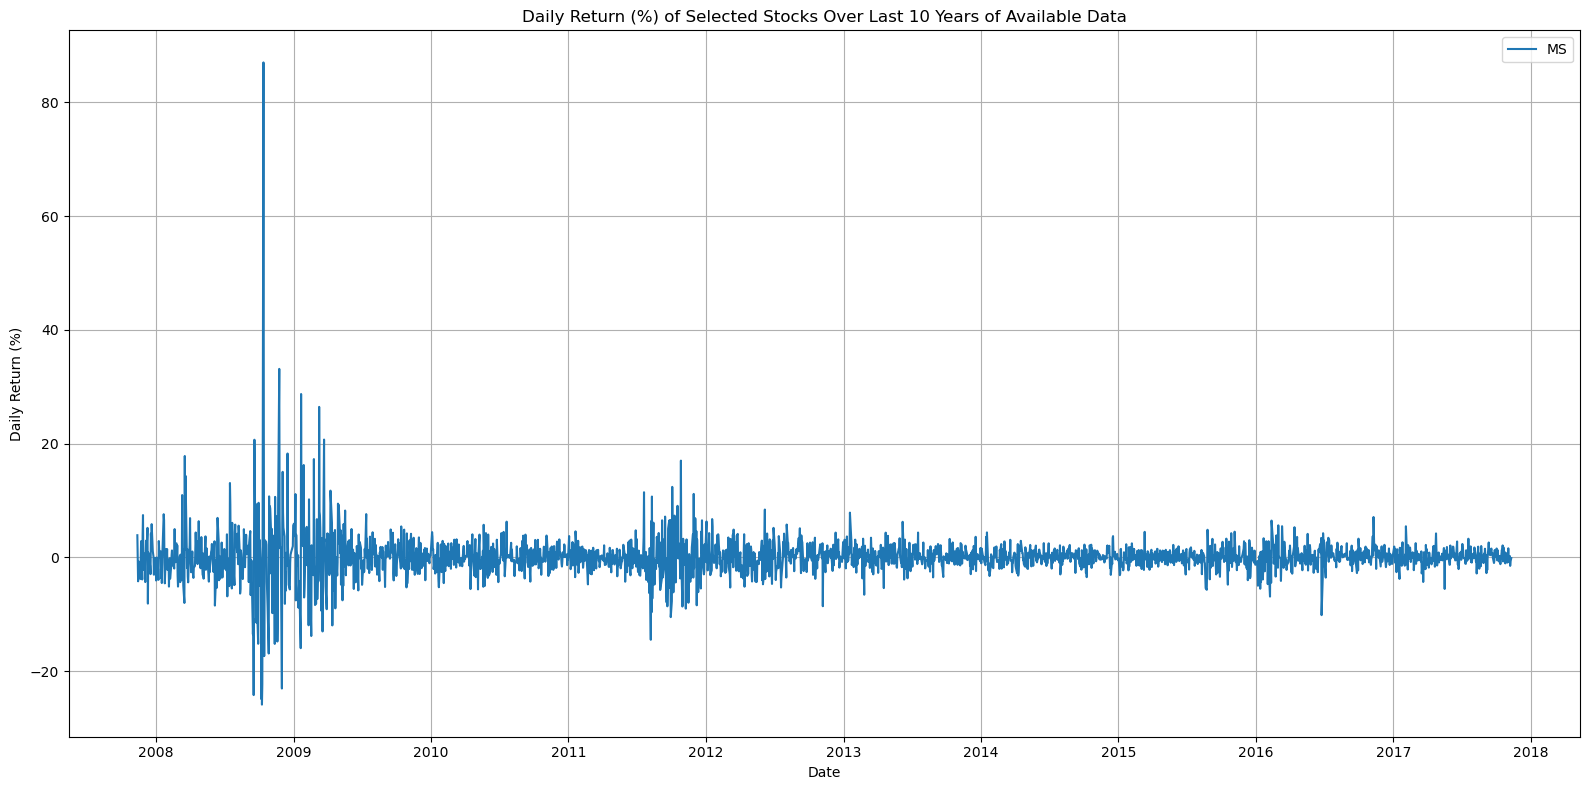

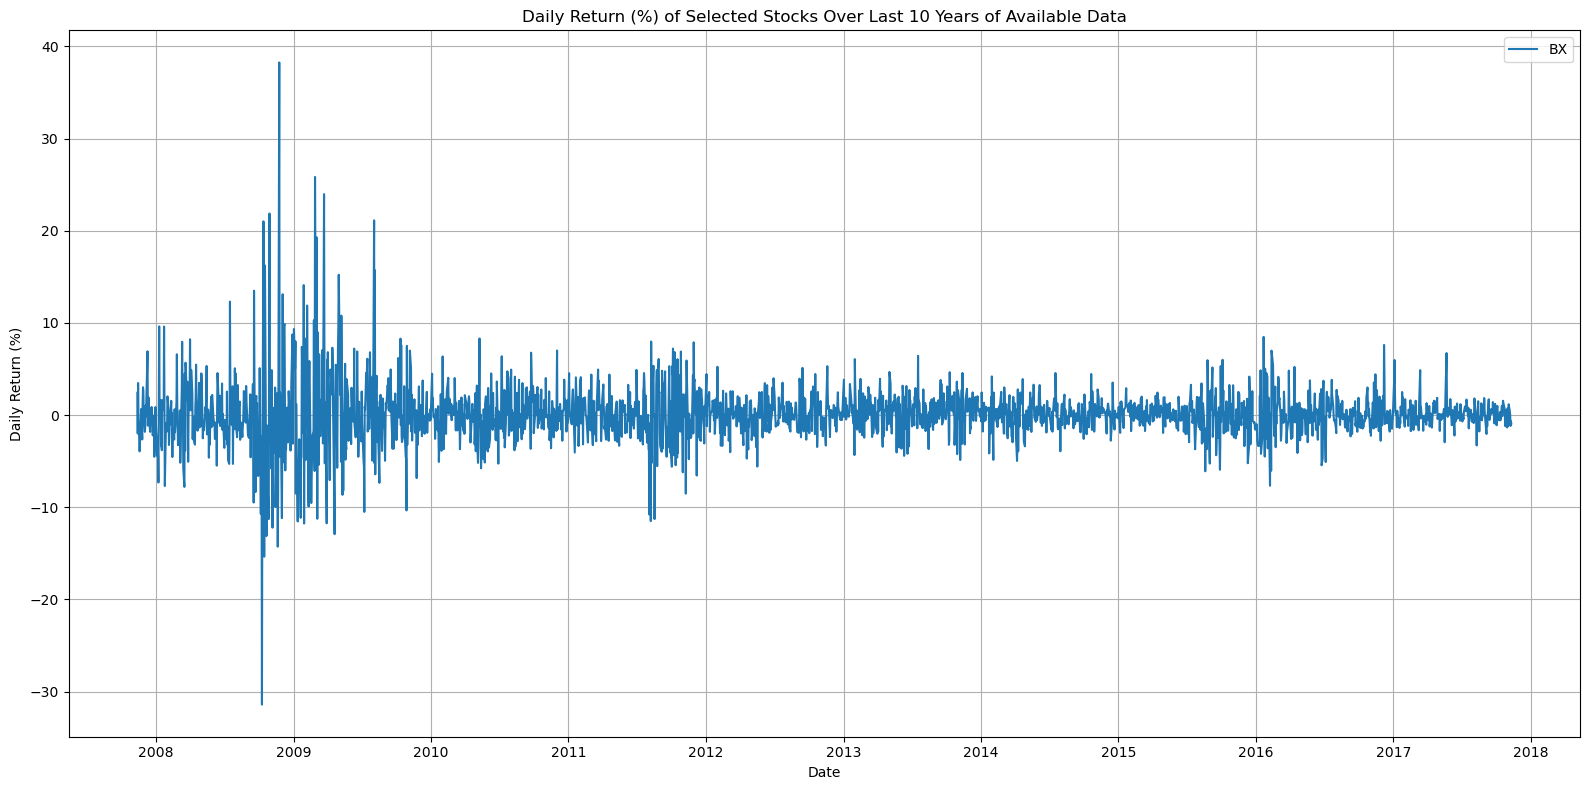

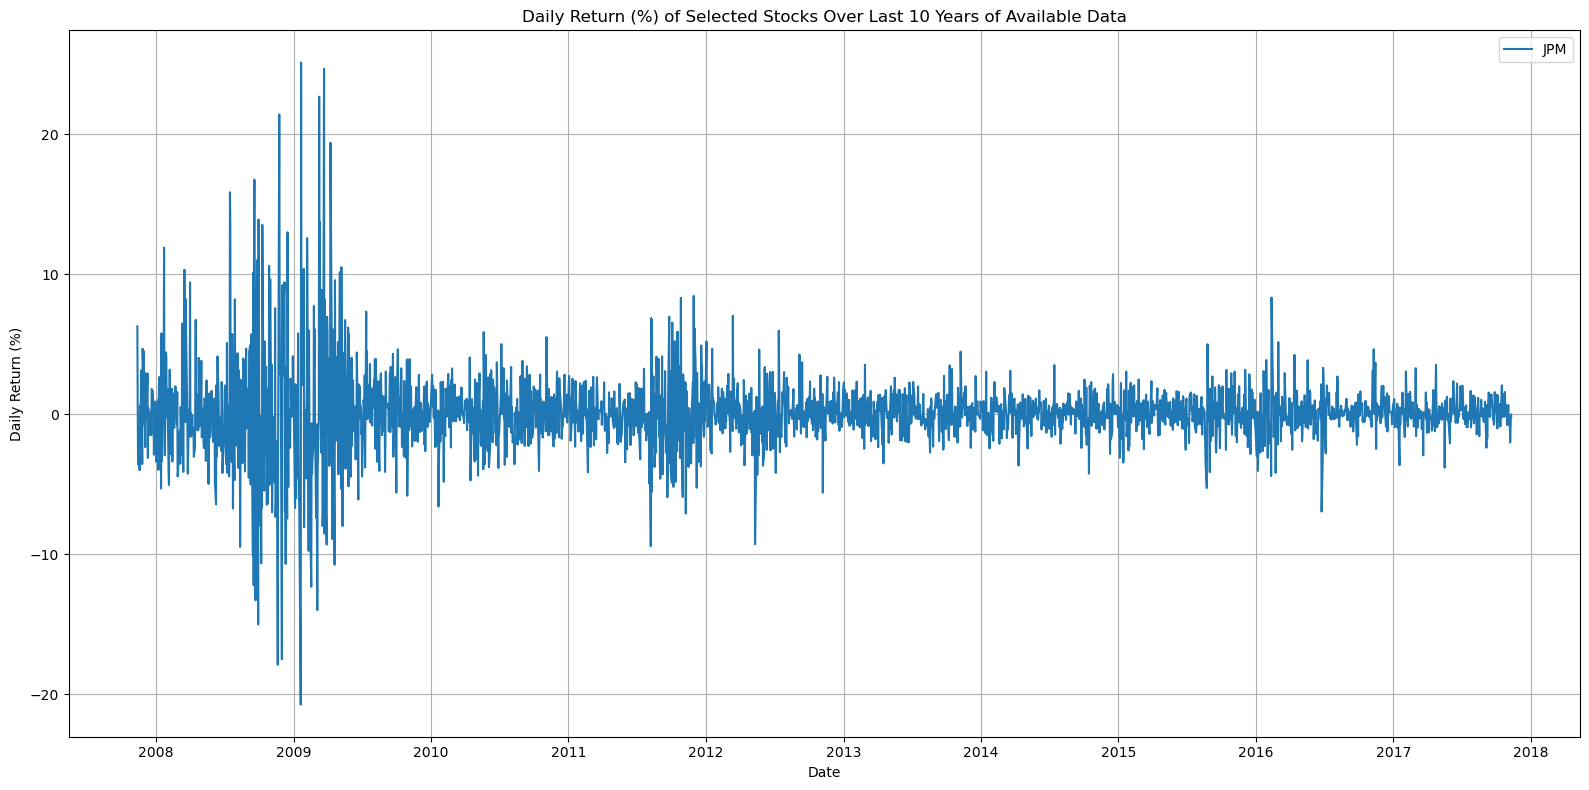

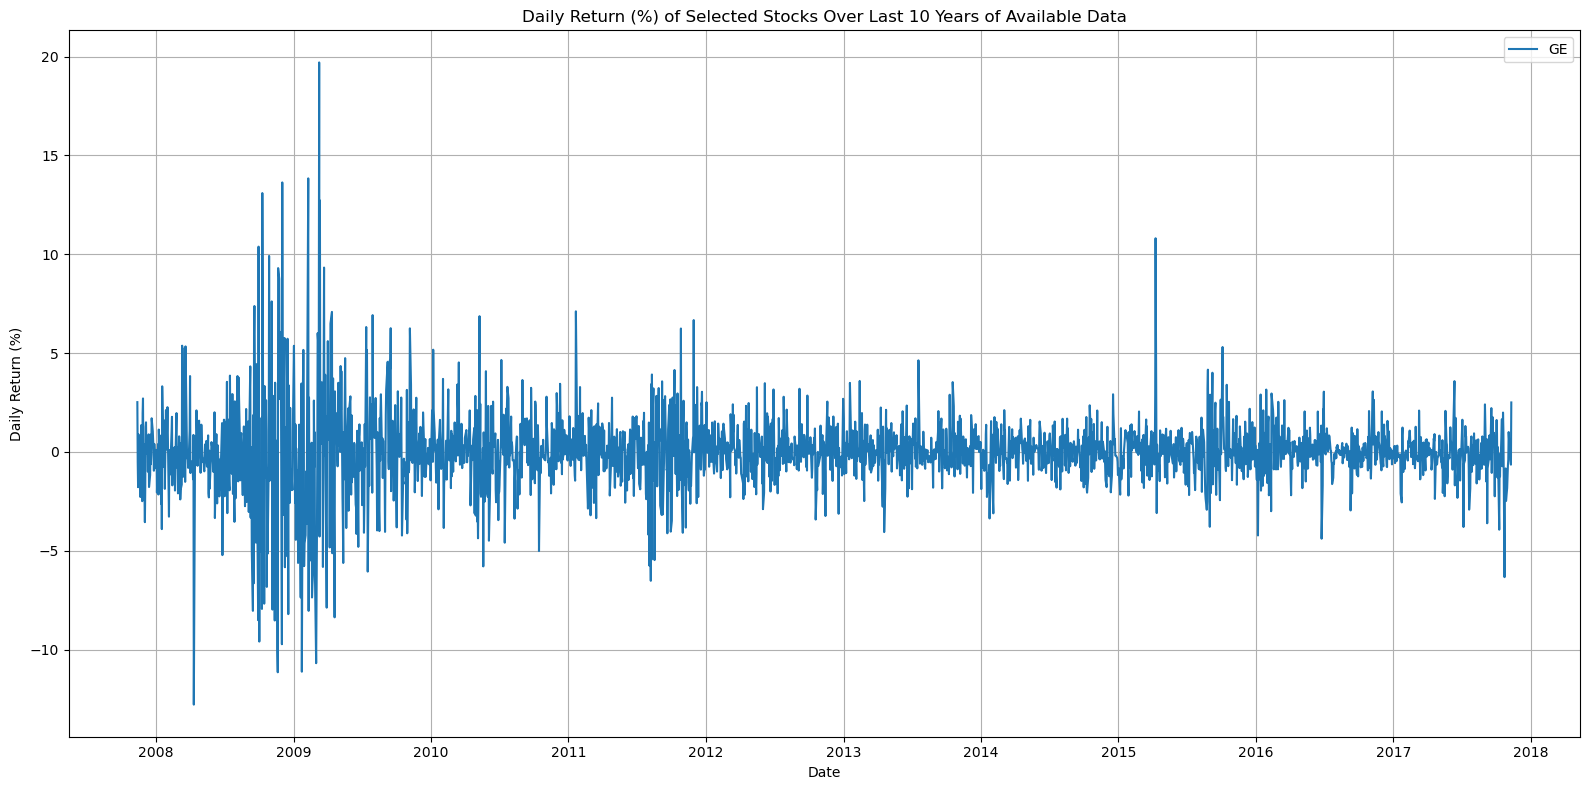

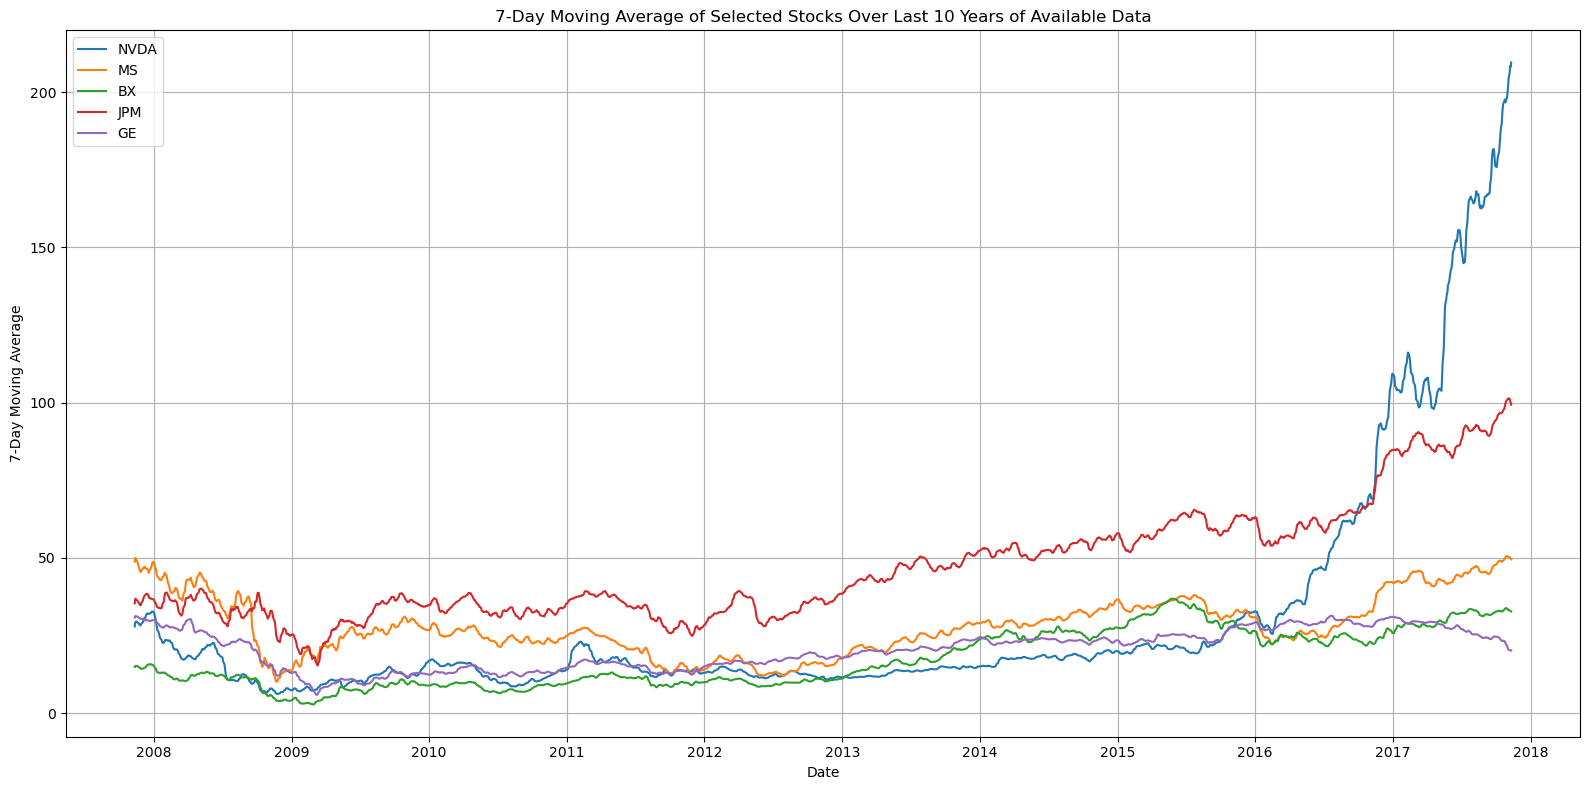

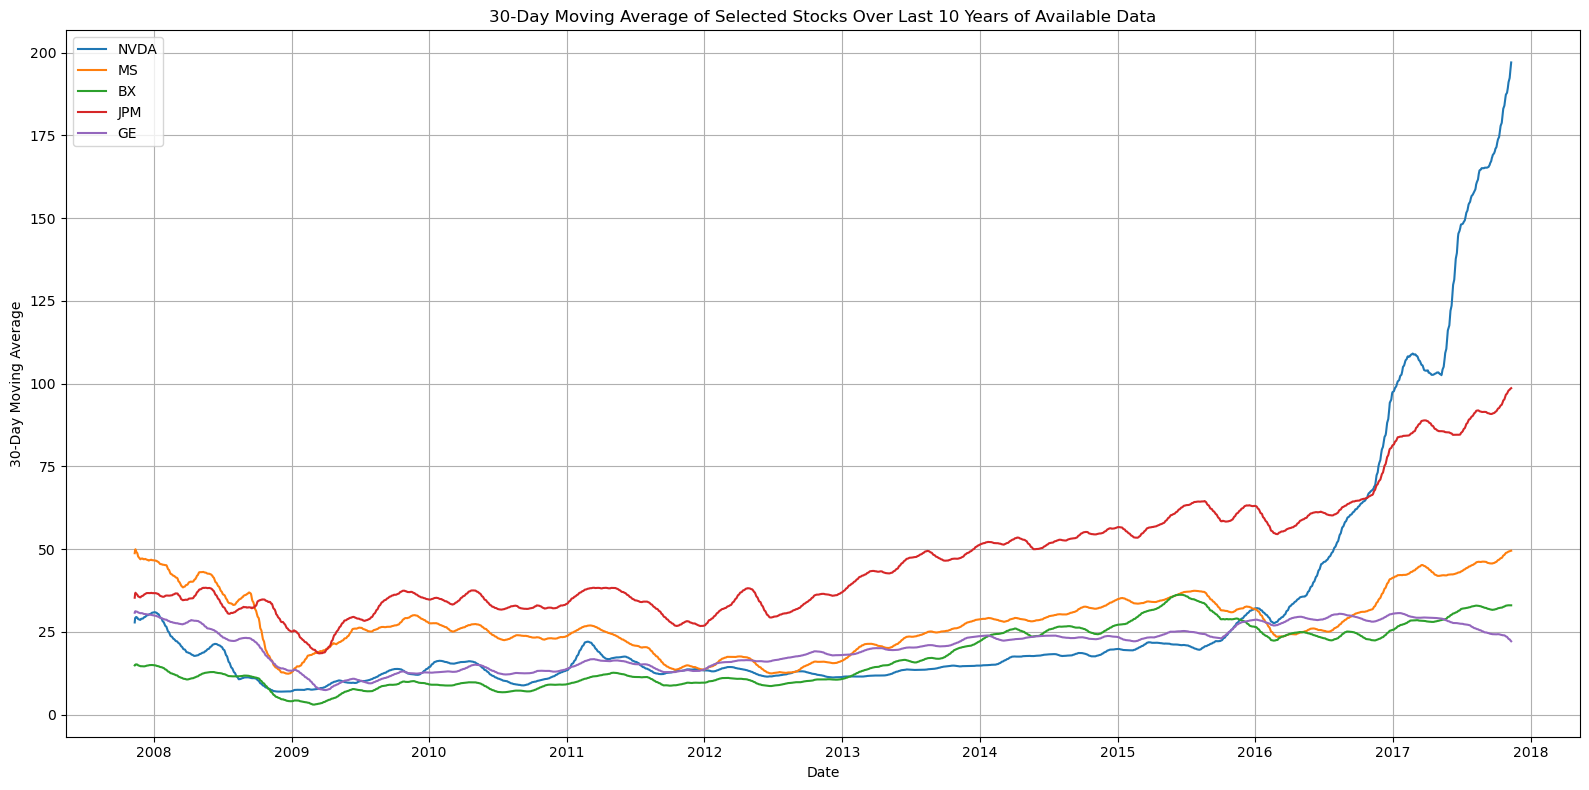

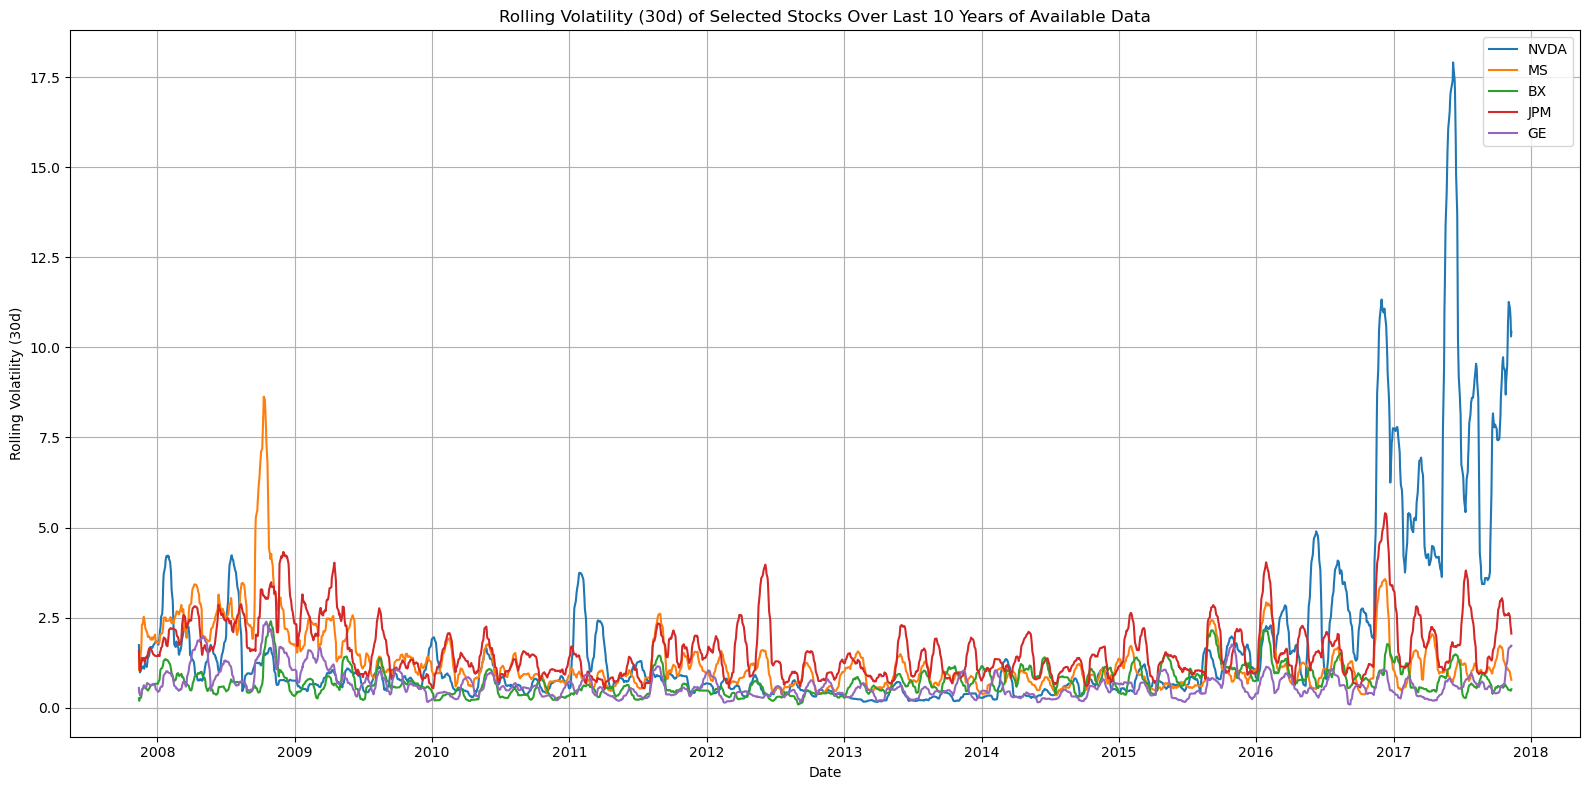

In [9]:
createPlot(tickers, "Close")

createPlot(tickers, "Daily Return (%)")
#daily return of some are hidden by others, so also plot individually
for ticker in tickers:
    createPlot([ticker], "Daily Return (%)")

createPlot(tickers, "7-Day Moving Average")

createPlot(tickers, "30-Day Moving Average")

createPlot(tickers, "Rolling Volatility (30d)")